# POPPY Simulation: Magellan Telescope

In [33]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope pulled from Oli Durney's MagAO-X Zemax file. (It may be in the data folder)

### To-do (not priority):
- Figure out pupil design to add as secondary obscuration
- Implement FITS file for primary mirror

In [34]:
testWavelength = 656e-9 * u.m # H-alpha band for NSF MagAO-X
npix = 256  # resolution

# physical radius values
M1_radius = 3.239204 * u.m 
M2_radius = 0.632573 * u.m 
#M3_radius = 0.334947 * u.m 
M3_radius = 0.439879 * u.m

# radius of curvature values
M1_roc = 16.26 * u.m
M2_roc = 2.862820 * u.m
fl_M1 = 8.128 * u.m
fl_M2 = M2_roc/2

# propagation distances from Zemax file
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_f11fp = 4.979516 * u.m 

# intermediary distances
d_m1fp_m2 = d_m1_m2 - fl_M1
d_m2_f11fp = d_m2_m3 + d_m3_f11fp

M1 = poppy.QuadraticLens(fl_M1, name='M1')
M2 = poppy.QuadraticLens(fl_M2, name='M2')
# M3 is a flat mirror so nothing to declare here

## Begin Magellan Telescope build

### Check Focal plane PSF of primary mirror

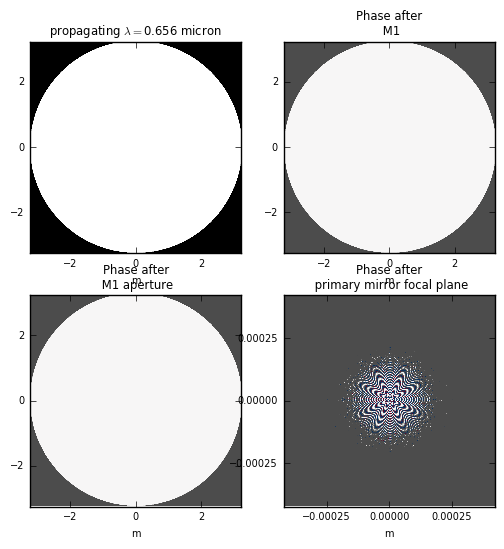

In [35]:
mag_tel = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*4,
                                       beam_ratio=0.34)#beam_ratio is the oversampling convention used in PROPER

# Entrance Aperture
mag_tel.add_optic(poppy.CircularAperture(radius=M1_radius))
# Add line of code here for pupil dimensions but need to get more info about spider + center obscuration

# NOTE: Surface # count determined by Laird's MagAO-X spreadsheet design.

# Surface -6: Primary Mirror (M1)
mag_tel.add_optic(M1)
mag_tel.add_optic(poppy.CircularAperture(radius=M1_radius,name="M1 aperture"))

# Look at the focal point of primary mirror
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="primary mirror focal plane"), distance=fl_M1)

matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[6,6])
m1psf, m1_wfs = mag_tel.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

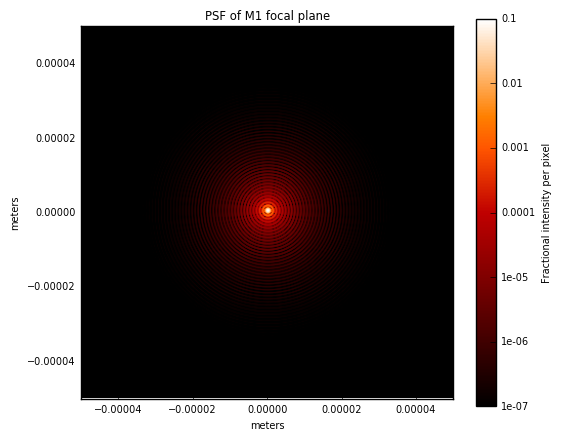

In [36]:
plt.figure(figsize=[6,5])
poppy.display_PSF(m1psf, imagecrop = 0.0001)
plt.title("PSF of M1 focal plane")
plt.xlabel("meters")
plt.ylabel("meters")

### Observe F/11 PSF from telescope

In [37]:
# Surface -5: Secondary Mirror (M2)
mag_tel.add_optic(M2, distance=d_m1fp_m2)
mag_tel.add_optic(poppy.CircularAperture(radius=M2_radius,name="M2 aperture"))

# Surface -4: Tertiary Mirror (M3, flat mirror)
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="M3 (flat)"), distance=d_m2_m3)
mag_tel.add_optic(poppy.CircularAperture(radius=M3_radius, name="M3 (flat) aperture"))

# Surface -3: F/11 Focal Plane
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane (unfixed)"), distance=d_m3_f11fp)

#### Comment on Focal Plane:
Zemax and POPPY have discrepancy for focal points. Zemax will find the optimal focus using real surfaces whereas POPPY calculates assuming paraxial rays and surfaces. Therefore, there needs to be a small correction installed to find the focal plane when using Zemax values.

In [38]:
# Focal plane correction for F/11
unfixed_f11fp_psf, unfixed_f11fp_wfs = mag_tel.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f11_last_wave = unfixed_f11fp_wfs[-1]
f11_delta = f11_last_wave.z_w0 - f11_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/11 PSF.
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane (corrected)"), distance=f11_delta)

F/11 Focal Plane Correction Distance:

In [41]:
f11_delta

<Quantity 0.027078593987432953 m>

Show corrected distance affects the phase value:

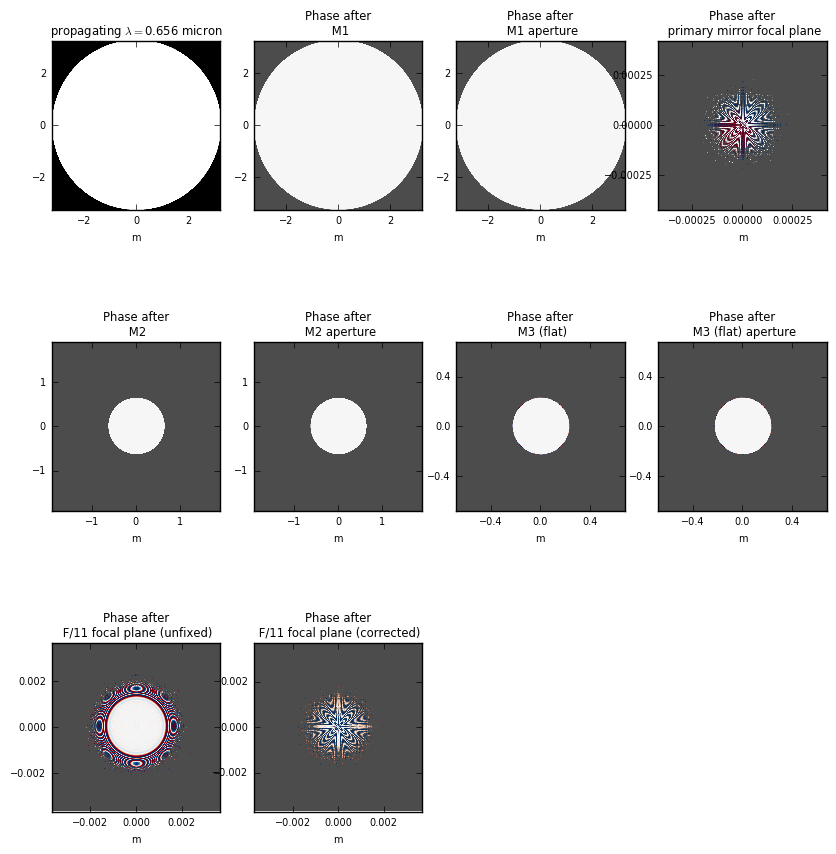

In [39]:
# Look at the corrected F/11 PSF
plt.figure(figsize=[10,11])
f11fp_psf, f11fp_wfs = mag_tel.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

### F/11 Telescope PSF

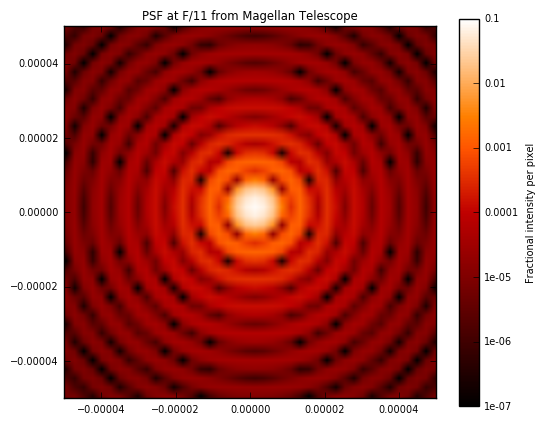

In [40]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f11fp_psf, imagecrop=0.0001)
plt.title("PSF at F/11 from Magellan Telescope")